# Problem 4 (for ASTRON 441 Students)

You will need to install picaso on your own machines following the [install instructions here](https://natashabatalha.github.io/picaso/installation.html). Note that you will need to download auxiliary files totaling around 6 GB. I recommend you follow the instructions in the link above, but if you are lazy, you can probably get away with running the code below. You will need to run the code below if you run this in Google Colab (note that in Colab, the downloading of files may take >= 1 hour depending on network traffic). 

In [ ]:
!pip install --user picaso
!git clone https://github.com/natashabatalha/picaso.git
!wget -O picaso/reference/opacities/opacities.db https://zenodo.org/record/3759675/files/opacities.db?download=1 

!wget http://ssb.stsci.edu/trds/tarfiles/synphot3.tar.gz
!tar -xvf synphot3.tar.gz 
!mv grp/redcat/trds/grid grid

import os
os.environ['picaso_refdata'] = os.path.join(os.getcwd(), 'picaso', 'reference')
os.environ['PYSYN_CDBS'] = os.getcwd()
print(os.environ['picaso_refdata'])

We also need to download a few other auxiliary files for this assignment. Step 1: we need to download [these Sonora models](https://zenodo.org/record/1309035/files/profile.tar?download=1), untar them, stick them in a folder, and set a variable to point to that folder. 

In [ ]:
!wget -O $picaso_refdata/sonora_profile.tar https://zenodo.org/record/1309035/files/profile.tar?download=1
!mkdir $picaso_refdata/sonora_profile
!tar -xvf $picaso_refdata/sonora_profile.tar -C $picaso_refdata/sonora_profile
import os
sonora_profile_db = os.path.join(os.environ['picaso_refdata'], 'sonora_profile')

Next we need to download [these cloud opacity files](https://zenodo.org/record/3992294/files/virga.zip?download=1), unzip them, stick them in a folder, and set a variable to point to that folder. 

In [ ]:
!wget -O $picaso_refdata/virga.zip https://zenodo.org/record/3992294/files/virga.zip?download=1
!mkdir $picaso_refdata/virga
!unzip $picaso_refdata/virga.zip -d $picaso_refdata/virga
import os
virga_dir = os.path.join(os.environ['picaso_refdata'], 'virga','virga_1e-7')

# Skip to here once you are done installing

Import packages

In [ ]:
import numpy as np
import picaso
import matplotlib.pylab as plt
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')
#picaso
from picaso import justdoit as jdi
from picaso import justplotit as jpi

#plotting
jpi.output_notebook()

# Define Planetary Parameters Here


In [200]:
# define bulk planet properties here
planet_temp = 1400
cloudy = True

# Simulate Spectra

In [201]:
# load opacity database
opa = jdi.opannection(wave_range=[1,5])

# create a new case to simulate
case1 = jdi.inputs()

case1.phase_angle(0) # we are not dealing with reflected light, so we can skip this

# here we are going to have to specify gravity through R and M since we need it in the Flux calc
case1.gravity(mass=1, mass_unit=jdi.u.Unit('M_jup'),
              radius=1., radius_unit=jdi.u.Unit('R_jup'))

# set the star so the code doesn't crash. We are doing thermal emission spectra and don't actually use the star in any way.
case1.star(opa, 5800,0.0122,4.437,radius=1, radius_unit = jdi.u.Unit('R_sun') )

# load in the atmospheric parameters given the effective temperature we chose
# someone did all the hard work to figure this out already
case1.sonora(sonora_profile_db,  planet_temp)

# if cloudy, turn on clousd
if cloudy:
    metallicity = 1 #1xSolar
    mean_molecular_weight = 2.2
    fsed=1
    gas_condensates = ['H2O','MnS','Mg2SiO4','Al2O3']

    #for the cloud code we have to supply a kzz value, which describes the degree of mixing
    p=case1.inputs['atmosphere']['profile']['pressure']
    case1.inputs['atmosphere']['profile']['kz'] = [1e9]*len(p)

    case1.virga(gas_condensates, virga_dir, fsed=fsed,mh=metallicity,
                 mmw = mean_molecular_weight,full_output=True)

# simulate the spectrum and store in a dataframe
df = case1.spectrum(opa, full_output=True,calculation='thermal')

# pull out some useful parameters
wno, fpfs , fp = df['wavenumber'] , df['fpfs_thermal'], df['thermal']
wno_bin, fpfs_bin = jdi.mean_regrid(wno, fpfs, R=500) # downsample the spectrum
wno_bin, fp_bin = jdi.mean_regrid(wno, fp, R=500) # downsample the spectrum
full_output = df['full_output']

# Produce plots

Use these plots to answer your homework. 

In [202]:
# Left: plot the pressure vs mixing ratio for various constitutents in the atmosphere
# Right: plot the pressure-temperature profile

jpi.show(jpi.row(
    jpi.mixing_ratio(full_output, plot_height=500, limit=10),
    jpi.pt(full_output, plot_height=500)))

In [203]:
# Plot the actual spectrum. Zoom in to look at features carefully! 

jpi.show(jpi.spectrum(wno_bin,fp_bin,plot_width=500))

In [204]:
# Plot the pressure correspoding to tau=1 for photons that interact with each individual species only! 
# The deeper the tau=1 surface, the less absorption there is from that species at that wavelength. 

contributors = jdi.get_contribution(case1, opa, at_tau=1)

contrib_species = contributors['tau_p_surface'].keys()

wno=[]
spec=[]
labels=[]
for j in contrib_species:
    x,y = jdi.mean_regrid(opa.wno, contributors['tau_p_surface'][j], R=500)
    if np.min(y)<5: # Bars
        wno+=[x]
        spec+=[y]
        labels +=[j]
        
fig = jpi.spectrum(wno,spec,plot_width=600,plot_height=350,y_axis_label='Tau~1 Pressure (bars)',
                   y_axis_type='log',x_range=[1,5],
                     y_range=[1e2,1e-4],legend=labels)

jpi.show(fig)

In [205]:
# Compare the spectrum with blackbody spectra. 
# Each blackbody spectrum is labeled with the temperature and the corresponding pressure in the PT profile
fig = jpi.flux_at_top(df, pressures=[10,1,0.1],R=500,plot_width=1000)
fig.legend.location='bottom_right'
jpi.show(fig)

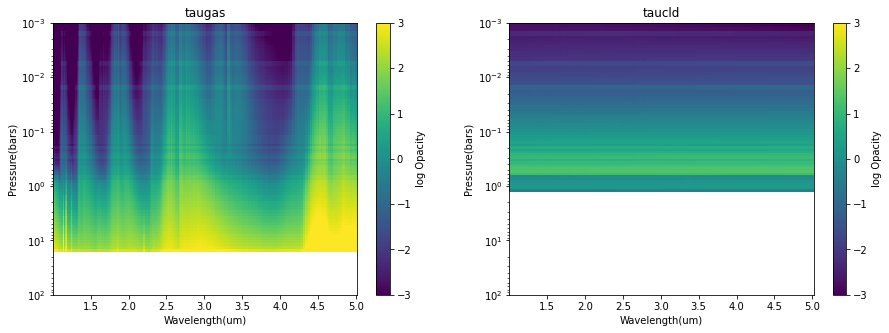

In [206]:
# For cloudy spectra, this plots the opacity as a function of wavelength and pressure. 
if cloudy:
    fig, ax = plt.subplots(ncols=2,figsize=(15,5))

    for it, itau in enumerate(['taugas','taucld']):

        tau_bin = []
        for i in range(df['full_output'][itau].shape[0]):
            x,y = jdi.mean_regrid(df['wavenumber'],
                                  df['full_output'][itau][i,:,0], R=150)
            tau_bin += [[y]]

        tau_bin = np.array(np.log10(tau_bin))[:,0,:]
        X,Y = np.meshgrid(1e4/x,df['full_output']['layer']['pressure'])
        Z = tau_bin
        pcm=ax[it].pcolormesh(X, Y, Z)
        cbar=fig.colorbar(pcm, ax=ax[it])
        pcm.set_clim(-3.0, 3.0)
        ax[it].set_title(itau)
        ax[it].set_yscale('log')
        ax[it].set_ylim([1e2,1e-3])
        ax[it].set_ylabel('Pressure(bars)')
        ax[it].set_xlabel('Wavelength(um)')
        cbar.set_label('log Opacity')